# Практика 5: Атака с ограниченной памятью (PGD - Projected Gradient Descent)
## Цель задания: Изучить одну из наиболее мощных атак на модели ИИ — атаку Projected Gradient Descent (PGD). Научиться использовать PGD для создания противоречивых примеров и оценить её влияние на обученные модели.
## Задачи:
1. Загрузить ранее обученную модель на датасете MNIST.
2. Изучить теоретические основы атаки PGD.
3. Реализовать атаку PGD с помощью фреймворка Foolbox.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.

## Шаги выполнения:
Шаг 1: Загрузка обученной модели и данных MNIST
Загружаем обученную модель и данные для проведения атаки.

In [5]:
# Чтобы постоянно не загружать датасет вручную, импрртируем его из первой практики
!wget https://github.com/l-Il/AZSII/raw/refs/heads/main/prz_1/mnist_model.h5

--2024-11-18 18:16:31--  https://github.com/l-Il/AZSII/raw/refs/heads/main/prz_1/mnist_model.h5
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/l-Il/AZSII/refs/heads/main/prz_1/mnist_model.h5 [following]
--2024-11-18 18:16:32--  https://raw.githubusercontent.com/l-Il/AZSII/refs/heads/main/prz_1/mnist_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1244464 (1.2M) [application/octet-stream]
Saving to: ‘mnist_model.h5’

mnist_model.h5      100%[===================>]   1.19M  --.-KB/s    in 0.05s   

2024-11-18 18:16:32 (22.8 MB/s) - ‘mnist_model.h5’ saved [1244464/1244464]



Импорт библиотек

In [ ]:
import torch
import torch.nn as nn

In [6]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

### Поскольку в процессе выполнения с датасетом из первой практики возникает ошибка, было принято решение конвертировать метки в one-hot
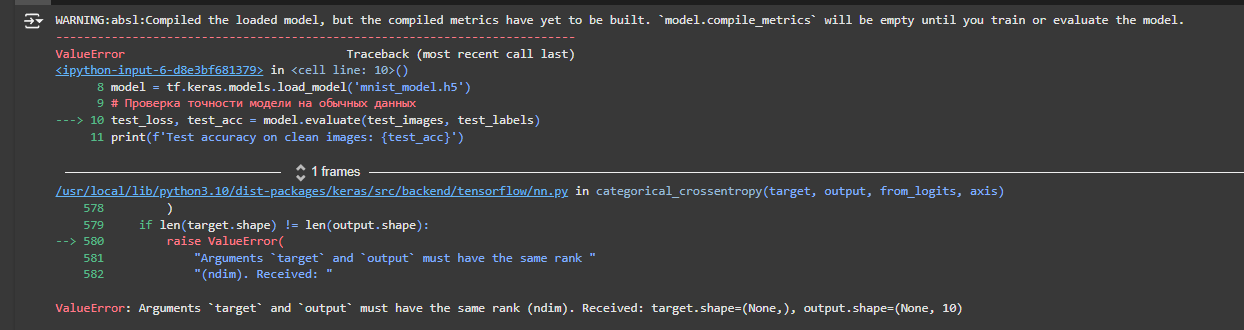

In [7]:
# Сама конвертация меток
from tensorflow.keras.utils import to_categorical
test_labels = to_categorical(test_labels, num_classes=10)

Продолжаем выполнять код

In [8]:
# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9726 - loss: 0.0869
Test accuracy on clean images: 0.9768999814987183


Шаг 2: Теория атаки Projected Gradient Descent (PGD)

Атака Projected Gradient Descent (PGD) — это расширение FGSM (Fast Gradient Sign Method), где атака выполняется итеративно. На каждой итерации добавляются небольшие изменения к входным данным в направлении увеличения ошибки модели. После каждой итерации результат "проецируется" на допустимое пространство для ограничивания размера изменений, что позволяет сохранять противоречивый пример в пределах определенной нормы (например, L∞).

Шаг 3: Реализация атаки PGD с использованием Foolbox

Теперь мы реализуем атаку PGD, используя фреймворк Foolbox, который упрощает запуск различных
атак на модели ИИ.

Установка Foolbox:

In [9]:
pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.5 MB/s eta 0:00:00


Реализация атаки DeepFool:

3


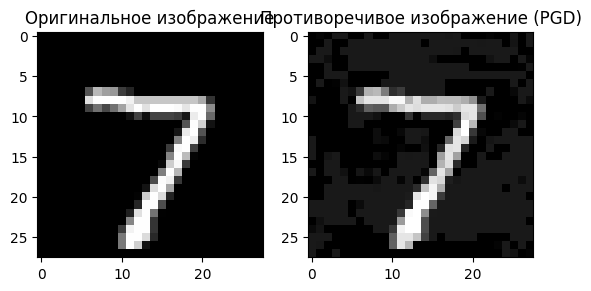

In [28]:
import foolbox as fb
import numpy as np

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Создание атаки PGD
attack = fb.attacks.LinfPGD()

# Выбор изображения для атаки
image = test_images[0]
label = test_labels[0]

# Исправляем ошибки
image = tf.convert_to_tensor(image, dtype=tf.float32)[None, ...]
label = tf.convert_to_tensor(np.argmax(label), dtype=tf.int64)[None]

# Выполнение атаки
adversarial_image = attack(fmodel, image, label, epsilons=0.1)

# Вывод оригинального и противоречивого изображения
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(adversarial_image[0][0].numpy(), cmap="gray")
plt.show()


Шаг 4: Оценка модели на противоречивых примерах

Теперь мы проверим, как сильно атака PGD влияет на точность модели. Мы создадим набор
противоречивых примеров и оценим производительность модели на этих данных.

In [43]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []
for i in range(len(test_images)):
  image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
  label = tf.convert_to_tensor(np.argmax(test_labels[i]), dtype=tf.int64)[None]
  adv_image = attack(fmodel, image, label, epsilons=0.1)
  adversarial_images.append(adv_image[0])
  print(i)
# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)  # Объединение по нулевой оси
# Убедитесь, что test_labels имеют соответствующее количество меток
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')

Выходные данные были обрезаны до нескольких последних строк (5000).
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
51

Шаг 5: Сравнение результатов

Сравните точность модели на обычных и противоречивых примерах. Ожидается значительное снижение точности на атакованных данных, что указывает на уязвимость модели перед PGD.

Результаты:
* accuracy: 0.0381
* loss: 7.8952
* Accuracy on adversarial examples (PGD): 0.04859999939799309

Точность модели на примерах, подвергнутых PGD-атаке, составляет всего 4.86%, что значительно ниже по сравнению с неатакованными данными.
Высокое значение loss (7.8952) подтверждает значительные ошибки предсказаний модели в условиях атаки, поэтому эта модель уязвима перед PGD.